# Offline Prediction calculation

This notebook is used to:
* read historydata.
* calculate predictions
* explore predictions via plots
* save predictions for online stream analysis.

## The data
The data contents summaries of metrics for unique combinations of the hashtags(case-unsensitive):
* #Trump
* #News
* #FakeNews
* #Democrats
* #Politics
The combination is generated with boolean flags for every hashtag.
If a tweet does not contain any of these hashtags, it links to a valid combination aswell. This combination is therefore '[false,false,false,false,false]'.

Summaries about the last 60 seconds are recorded every second for every unique hashtag combination. If a combination did not occure in this timewindow, no summary is recorded for this combination.

### Used metrics
Following metrics were calculated for every occuring hashtag combination in a timewindow of the last 60 seconds:
* count - The total count of tweets for this combination
* meanTextLength - the mean length of a not truncated tweet (hashtags and mentions included)
* meanHashtagCount - The mean count of hashtags
* meanTrumpCount - The mean occurences of the word 'trump' in the tweet texts; not case-sensitive.
* meanSensitiveCount - The mean count of tweets flagged as "Possibly sensitive". (Flagging performed by Twitter)

These metrics are used to generate a prediction for hashtag combinations w.r.t. the time of the day.

## Used libaries
Make sure those are installed.

In [1]:
import pandas as pd
import numpy as np
import datetime
from datetime import timedelta

### Plotting
And display in notebook.

In [2]:
import matplotlib
import matplotlib.pyplot as plt
import pylab
pylab.rcParams['figure.figsize'] = (16.0, 9.0)
%matplotlib inline

## Reading history CSV files

In [3]:
# The main working directory
mainDir = ""

comboHistoryFile = mainDir + "comboHistory.csv"

# The prediction filepaths
outputFile = mainDir + "timePredictions.csv"

In [4]:
comboHistory = pd.read_csv(comboHistoryFile,
                           sep=";", 
                           header = 0)

print("Number of summaries for hashtag-combinations: " + str(len(comboHistory)))

Number of summaries for hashtag-combinations: 728330


The data has following columns:

In [5]:
comboHistory.columns

Index(['timestamp', 'time', 'isTrumpTweet', 'isNewsTweet', 'isFakeNewsTweet',
       'isDemocratsTweet', 'isPoliticsTweet', 'count', 'meanTextLength',
       'meanHashtagCount', 'meanTrumpCount', 'meanSensitiveCount'],
      dtype='object')

In [6]:
comboHistory['timestamp'] = pd.to_datetime(comboHistory['timestamp']) + timedelta(hours=1)
comboHistory['time'] = pd.to_datetime(comboHistory['time']).apply(lambda x: x.time())

#### Plotfunction definition:

In [7]:
def plotMetric(df,metricName):
    traces = list()
    
    fig = plt.figure(figsize=(16,9))
    ax = plt.axes()

    for i in range(0,len(df)):
        df.plot(y=metricName, kind = 'bar', label=i, ax=ax)
    ax.legend().set_visible(False)

    plt.ylabel(metricName)
    
    plt.title('Mean of Metric: ' + metricName, fontsize=18)

In [8]:
def plotMetricTimeseries(dfList, metricName, timeName = 'timestamp', skip=0, kind = 'line'):
    traces = list()
    
    fig = plt.figure(figsize=(16,9))
    ax = plt.axes()

    for i in range(skip,len(dfList)):
        df = dfList[i]
        df.plot(x=timeName, y=metricName, label=i, ax=ax, linewidth = 0.5, kind = kind)
        
    titleStr= 'Timeseries of Metric: ' + metricName
    
    
    plt.xlabel(timeName)
    plt.ylabel(metricName)
    plt.suptitle('Timeseries of Metric: ' + metricName, fontsize=18)
    
    if(skip>0):
       plt.title('(skipped ' + str(skip) + ' datarows)', fontsize=10)
    
    plt.legend()

Due to the quantity of unique combinations, refer to this table for index-combo linking.

## Predictions
This approach merges the entries by their time (without a date) and their combo.    
The goal is to achieve a mean-value for each combo and each second of a day.

This mean value functions as prediction for this metric. The Spark application will use and evaluate this prediction.

In [9]:
newComboHistory = comboHistory.copy()

In [10]:
# transform timestamp strings to datetime format
# if wanted, use offsets for testing
offsetH = 0
offsetm = 0
offsets = 0
newComboHistory['time'] = newComboHistory['timestamp'] + timedelta(hours=offsetH, minutes = offsetm, seconds = offsets)
newComboHistory['time'] = newComboHistory['time'].apply(lambda x: x.time())

In [11]:
# group by hashtag combination, calculate mean values of metrics
meanPredictions = newComboHistory.groupby(['isTrumpTweet','isNewsTweet','isFakeNewsTweet','isDemocratsTweet','isPoliticsTweet'])['count'].agg(np.mean).reset_index()
print("Found " + str(len(meanPredictions)) + " unique hashtag combinations")

Found 22 unique hashtag combinations


In [12]:
timePredictions = newComboHistory.groupby(['time',
                                           'isTrumpTweet',
                                           'isNewsTweet',
                                           'isFakeNewsTweet',
                                           'isDemocratsTweet',
                                           'isPoliticsTweet'])['count',
                                                               'meanTextLength',
                                                               'meanHashtagCount', 
                                                               'meanTrumpCount', 
                                                               'meanSensitiveCount'].agg(np.mean).reset_index()
print("Number of predictions: " + str(len(timePredictions)))

Number of predictions: 527871


## Plot predictions

In [13]:
comboList = list()
for i in range(0, len(meanPredictions)):
    comboList.append(meanPredictions.loc[i,['isTrumpTweet',
                                            'isNewsTweet',
                                            'isFakeNewsTweet',
                                            'isDemocratsTweet',
                                            'isPoliticsTweet']].to_frame().transpose())

In [14]:
timePredictionsList = list()
for i in range(0,len(comboList)):
    timePredictionsList.append(comboList[i]
                               .merge(timePredictions,on=['isTrumpTweet',
                                                          'isNewsTweet',
                                                          'isFakeNewsTweet',
                                                          'isDemocratsTweet',
                                                          'isPoliticsTweet']))

In [15]:
meanPredictions.loc[:,['isTrumpTweet','isNewsTweet','isFakeNewsTweet','isDemocratsTweet','isPoliticsTweet']]

,isTrumpTweet,isNewsTweet,isFakeNewsTweet,isDemocratsTweet,isPoliticsTweet
0,False,False,False,False,False
1,False,False,False,False,True
2,False,False,False,True,False
3,False,False,False,True,True
4,False,False,True,False,False
5,False,False,True,False,True
6,False,False,True,True,False
7,False,True,False,False,False
8,False,True,False,False,True
9,False,True,False,True,False


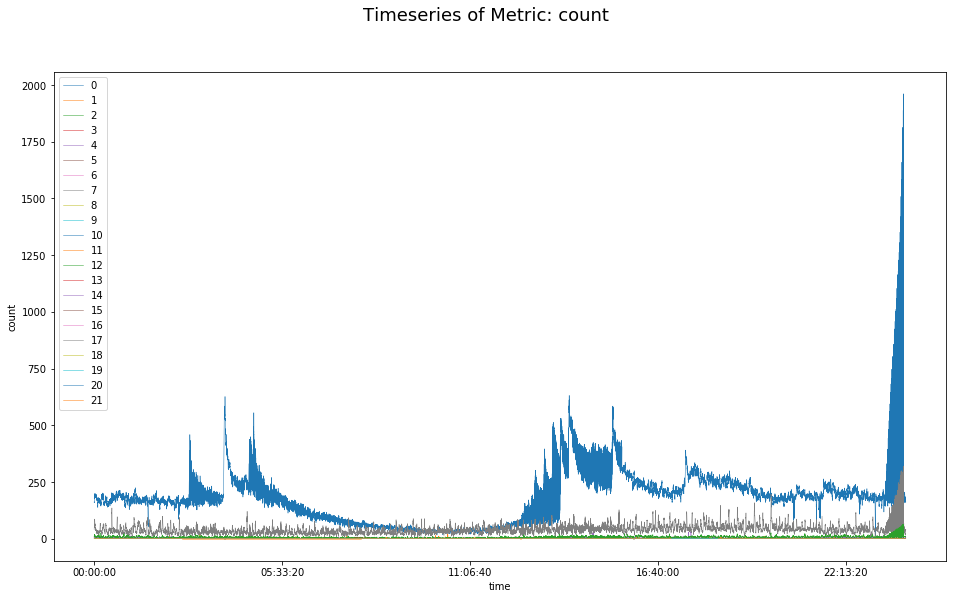

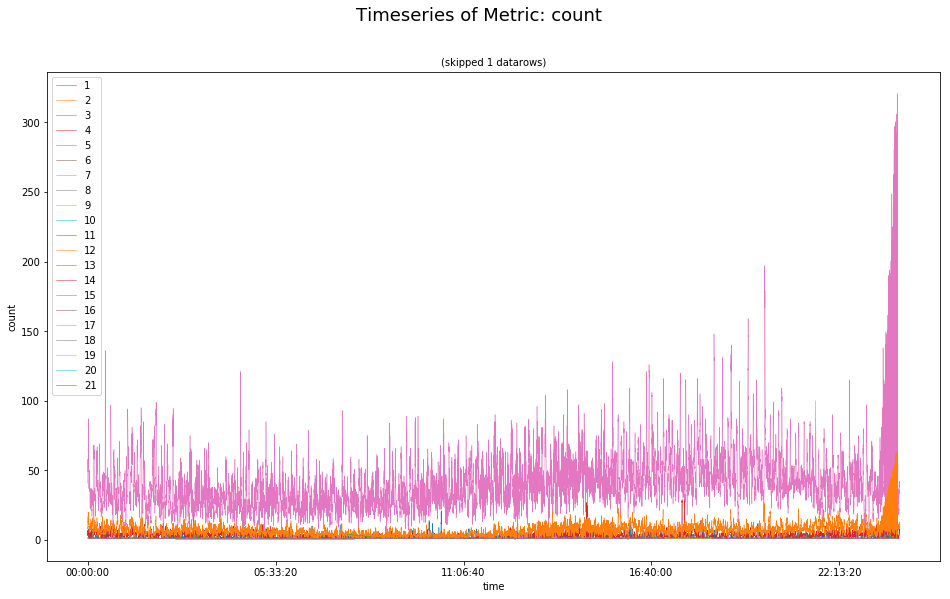

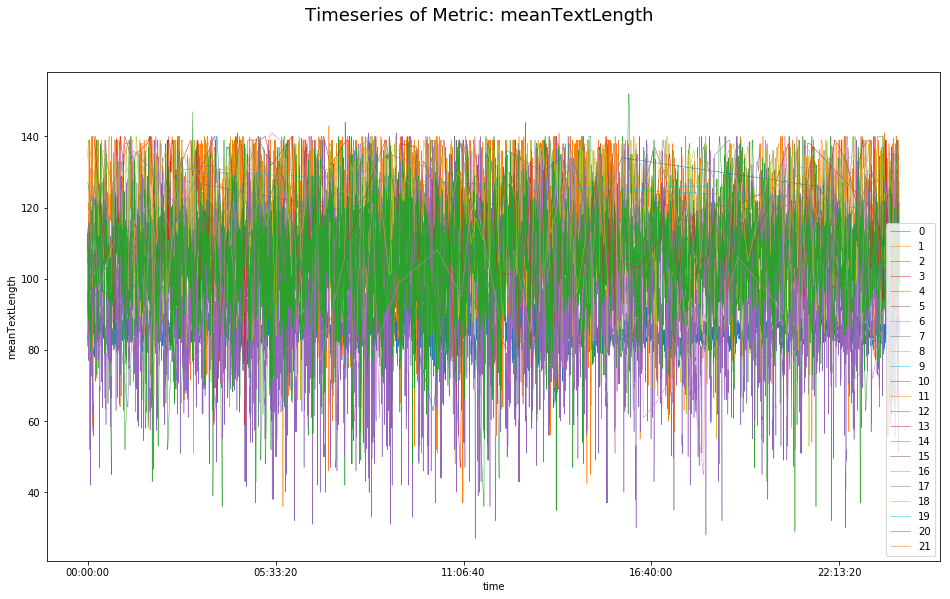

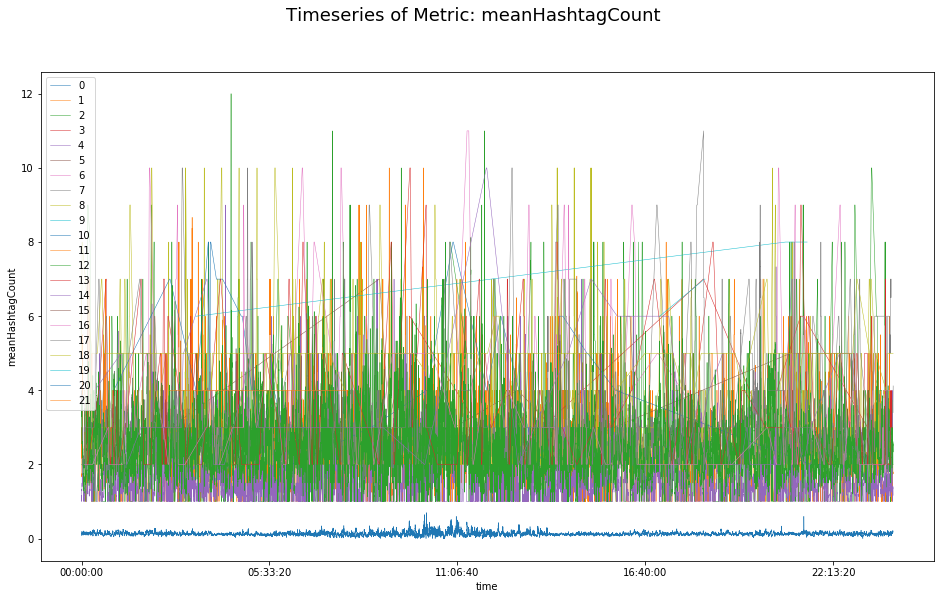

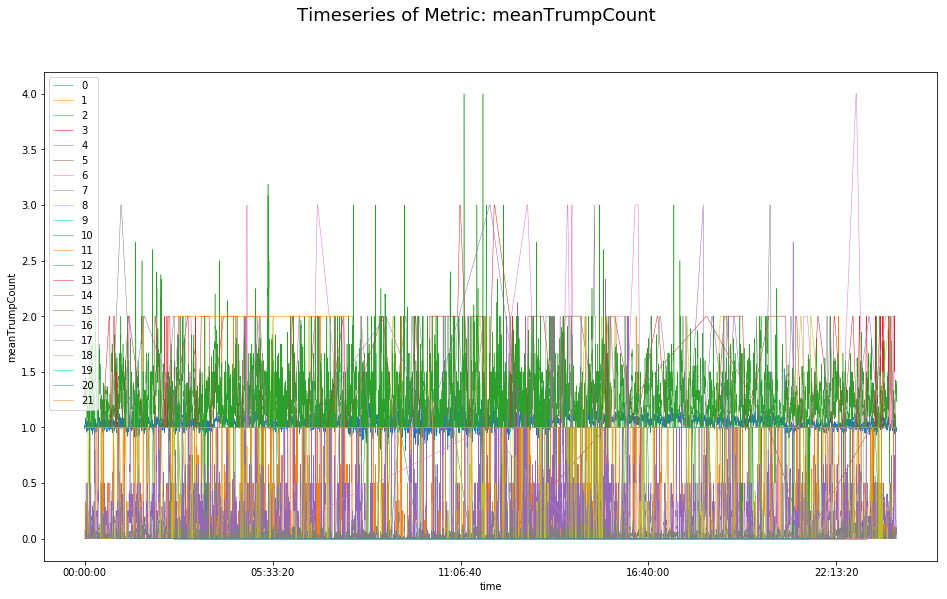

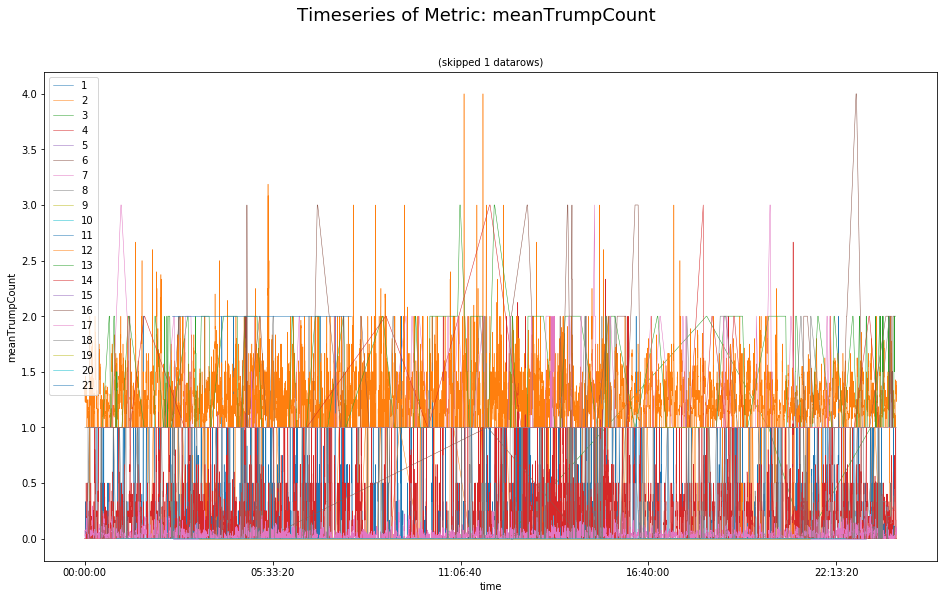

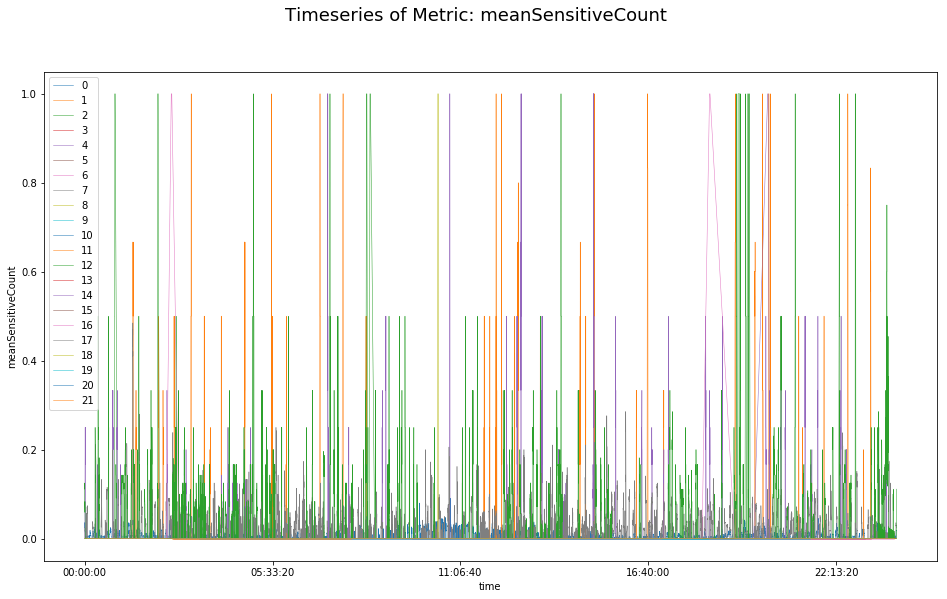

In [16]:
plotMetricTimeseries(timePredictionsList, 'count', timeName = 'time')
plotMetricTimeseries(timePredictionsList, 'count', timeName = 'time', skip = 1)
plotMetricTimeseries(timePredictionsList, 'meanTextLength', timeName = 'time')
plotMetricTimeseries(timePredictionsList, 'meanHashtagCount', timeName = 'time')
plotMetricTimeseries(timePredictionsList, 'meanTrumpCount', timeName = 'time')
plotMetricTimeseries(timePredictionsList, 'meanTrumpCount', timeName = 'time', skip = 1)
plotMetricTimeseries(timePredictionsList, 'meanSensitiveCount', timeName = 'time')

#### Save predictions as csv file

In [17]:
timePredictions.to_csv(outputFile,
                       sep=';',
                       quotechar='"',
                       quoting=2,
                       index=False)